<a href="https://colab.research.google.com/github/Rouic/classification-experiment-ml/blob/main/Fine_tuning_RoBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Imports

In [2]:
%%capture
!pip install transformers
!pip install pytorch-lightning

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, AdamW, get_scheduler, AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, hamming_loss, precision_score, recall_score
# Use progress bar
from tqdm.auto import tqdm
from collections import Counter
import pandas as pd
from torch.utils.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [4]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Hyperparameters
learning_rate = 2e-5  # Adjust if needed
batch_size = 16     # Adjust if needed
dropout_rate = 0.2   # Adjust dropout rate (0.1 - 0.5 usually work well)
random_seed = 42    # Adjust random seed for reproducibility
epochs = 10
threshold_list = [0.5, 0.7, 0.9]  # Adjust threshold values as needed
patience_to_not_improve = 5
model_name = 'roberta-base'  # Adjust the model name if needed
max_token_length = 128  # Adjust the max token length if needed
sample = 100
warmup = 0.2
weight_decay = 0.001
test_size = 0.2
num_sanity_val_steps = 1

In [6]:
# Add EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='validation loss ',  # Metric to monitor for improvement (changed from 'val_loss')
    patience=patience_to_not_improve,  # Number of epochs with no improvement before stopping
    verbose=True,  # Print messages about early stopping
    mode='min'  # 'min' for minimizing the metric, 'max' for maximizing
)

In [7]:
# Local data
label_names = [
    "R0",
    "B5",
]

text_examples = [
    {"text": "I like to start a mixer", "labels": ["R0"], "confidence":[0.90]},
    {"text": "I like to change my chart to a mixer chart", "labels": ["R0"], "confidence":[0.90]},
    {"text": "Mixer", "labels": ["R0"], "confidence":[0.90]},
    {"text": "I don't want a simple chart", "labels": ["R0"], "confidence":[0.90]},
    {"text": "I like to have multiple chart together in one", "labels": ["R0"], "confidence":[0.90]},
    {"text": "I like to combine multiple charts", "labels": ["R0"], "confidence":[0.90]},
    {"text": "I like to have a gauge", "labels": ["B5"], "confidence":[0.90]},
    {"text": "I need a gauge", "labels": ["B5"], "confidence":[0.90]},
    {"text": "Gauge.", "labels": ["B5"], "confidence":[0.90]},
    {"text": "Progress line", "labels": ["B5"], "confidence":[0.90]},
    {"text": "Progress bar", "labels": ["B5"], "confidence":[0.90]},
    {"text": "line", "labels": ["B5"], "confidence":[0.90]},
    {"text": "I like to have a line", "labels": ["B5"], "confidence":[0.90]},
]

#labels = [[1 if label in example["labels"] else 0 for label in label_names] for example in text_examples]


labels = []
for example in text_examples:
  attributes = []
  for label in label_names:
    if label in example["labels"]:
      # Find the index of the label in item['labels']
      label_index = example["labels"].index(label)
      # Use the corresponding confidence score
      attributes.append(example ['confidence'][label_index])
    else:
      attributes.append(0.0)  # If label not present, use 0 confidence
  labels.append(attributes)


labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(text_examples, labels, test_size=test_size, random_state=random_seed)
X_train, y_train

([{'text': 'Gauge.', 'labels': ['B5'], 'confidence': [0.9]},
  {'text': 'I like to combine multiple charts',
   'labels': ['R0'],
   'confidence': [0.9]},
  {'text': 'Mixer', 'labels': ['R0'], 'confidence': [0.9]},
  {'text': 'I like to change my chart to a mixer chart',
   'labels': ['R0'],
   'confidence': [0.9]},
  {'text': 'I like to have a line', 'labels': ['B5'], 'confidence': [0.9]},
  {'text': 'I like to have multiple chart together in one',
   'labels': ['R0'],
   'confidence': [0.9]},
  {'text': 'I need a gauge', 'labels': ['B5'], 'confidence': [0.9]},
  {'text': 'Progress bar', 'labels': ['B5'], 'confidence': [0.9]},
  {'text': "I don't want a simple chart",
   'labels': ['R0'],
   'confidence': [0.9]},
  {'text': 'I like to have a gauge', 'labels': ['B5'], 'confidence': [0.9]}],
 array([[0. , 0.9],
        [0.9, 0. ],
        [0.9, 0. ],
        [0.9, 0. ],
        [0. , 0.9],
        [0.9, 0. ],
        [0. , 0.9],
        [0. , 0.9],
        [0.9, 0. ],
        [0. , 0.9]

<Axes: >

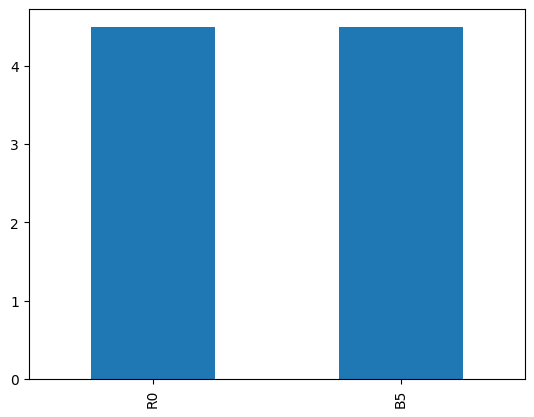

In [8]:
# Create a DataFrame with X_train and y_train for easier manipulation
df_train = pd.DataFrame({'text': X_train, 'R0': y_train[:, 0], 'B5': y_train[:, 1]})

# Now you can plot the sum of your labels
df_train[label_names].sum().plot.bar()


In [9]:
class Node_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, attributes, max_token_len: int = max_token_length, sample = sample):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()

  def _prepare_data(self):
    data = pd.DataFrame(self.data_path)
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    item = self.data.iloc[index]
    text = str(item.text)
    # use confidence scores:
    attributes = []
    for label in self.attributes:
      if label in item['labels']:
          # Find the index of the label in item['labels']
          label_index = item['labels'].index(label)
          # Use the corresponding confidence score
          attributes.append(item['confidence'][label_index])
      else:
          attributes.append(0.0)  # If label not present, use 0 confidence

    attributes = torch.FloatTensor(attributes)  # Convert to FloatTensor
    tokens = self.tokenizer.encode_plus(text,
                                        add_special_tokens=True,
                                        return_tensors='pt',
                                        truncation=True,
                                        padding='max_length',
                                        max_length=self.max_token_len,
                                        return_attention_mask = True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

# X_train AND X_test is the entire data with all fields...
node_ds =  Node_Dataset(X_train, tokenizer, attributes=label_names)
node_ds_val =  Node_Dataset(X_test, tokenizer, attributes=label_names, sample=None)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [11]:
node_ds.__getitem__(0)['labels'].shape, node_ds.__getitem__(0)['input_ids'].shape, node_ds.__getitem__(0)['attention_mask'].shape

(torch.Size([2]), torch.Size([128]), torch.Size([128]))

In [12]:
len(node_ds), len(node_ds_val)

(10, 3)

In [13]:
node_ds.__getitem__(0)

{'input_ids': tensor([   0,  534, 1180, 1899,    4,    2,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

In [14]:
class Node_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path, attributes, batch_size: int = batch_size, max_token_length: int = max_token_length,  model_name = model_name):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_length = max_token_length
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)

  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = Node_Dataset(self.train_path, attributes=self.attributes, tokenizer=self.tokenizer)
      self.val_dataset = Node_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)
    if stage == 'predict':
      self.val_dataset = Node_Dataset(self.val_path, attributes=self.attributes, tokenizer=self.tokenizer, sample=None)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=4, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

  def predict_dataloader(self):
    return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=4, shuffle=False)

In [15]:
node_data_module = Node_Data_Module(X_train, X_test, attributes=label_names)

In [16]:
node_data_module.setup()

In [17]:
node_data_module.train_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
len(node_data_module.train_dataloader())

1

In [19]:
class Node_Text_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()

  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)

    # Get confidence scores from the batch
    confidence_scores = batch["labels"]

    # Calculate loss
    loss = self.loss_func(outputs.view(-1, self.config['n_labels']), batch["labels"].view(-1, self.config['n_labels']))

    # Manually apply weights to the loss using confidence_scores for each sample
    weights = confidence_scores
    weighted_loss = torch.mean(loss * weights)

    self.log("train loss ", weighted_loss, prog_bar=True, logger=True)
    return {"loss": weighted_loss, "predictions": outputs, "labels": batch["labels"]}

    #loss, outputs = self(**batch)
    #self.log("train loss ", loss, prog_bar = True, logger=True)
    #return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss ", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)

In [20]:
config = {
    'model_name': model_name,
    'n_labels': len(label_names),
    'batch_size': batch_size,
    'lr': learning_rate,
    'warmup': warmup,
    'train_size': len(node_data_module.train_dataloader()),
    'weight_decay': weight_decay,
    'n_epochs': epochs
}

model = Node_Text_Classifier(config)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
idx=0
input_ids = node_ds.__getitem__(idx)['input_ids'].to(device) # Move input_ids to device
attention_mask = node_ds.__getitem__(idx)['attention_mask'].to(device) # Move attention_mask to device
labels = node_ds.__getitem__(idx)['labels'].to(device) # Move labels to device
model.to(device)
loss, output = model(input_ids.unsqueeze(dim=0), attention_mask.unsqueeze(dim=0), labels.unsqueeze(dim=0))
print(labels, output, loss)

tensor([0.0000, 0.9000]) tensor([[ 0.0350, -0.4735]], grad_fn=<AddmmBackward0>) tensor(0.8105, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


# Train model

In [22]:
# datamodule
node_data_module = Node_Data_Module(X_train, X_test, attributes=label_names, batch_size=config['batch_size'])
node_data_module.setup()

# model
model = Node_Text_Classifier(config)

# trainer and fit
trainer = pl.Trainer(
    max_epochs=config['n_epochs'],
    accelerator=device,
    devices=1,
    num_sanity_val_steps=num_sanity_val_steps,
    callbacks=[early_stopping_callback]  # callback to stop training if model not improving
)
trainer.fit(model, node_data_module)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params | Mode 
------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric validation loss  improved. New best score: 0.670


Validation: |          | 0/? [00:00<?, ?it/s]

Process Process-17:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 334, in _exit_function
    _run_finalizers(0)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 218, in __call__
    if self._pid != getpid():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid 54388) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs/

# Make a prediction

In [ ]:
# method to convert list of text into predictions for each text
def classify_raw_text(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

In [ ]:
predictions = classify_raw_text(model, node_data_module)
predictions

In [ ]:
# use argmax to get the highest estimated prediction and the class lable to show what is the prediction
def get_predictions(y_pred):
    predicted_indices = np.argmax(y_pred, axis=1)
    confidence_scores = np.max(y_pred, axis=1)
    return {"label_pred": predicted_indices, "confidence": confidence_scores}

def get_lable(lable_names, confidence, trashhold, top_pred, example_confidence):
    # Adjust threshold based on example confidence
    adjusted_threshold = trashhold * example_confidence

    if confidence >= adjusted_threshold:
        return lable_names[top_pred]
    else:
        return 'Sorry, Im not sure...'

'''
def get_lable(lable_names, confidence, trashhold, top_pred):
    # Check if the prediction probability (from argmax) is greater than or equal to the threshold
    if confidence >= trashhold:  # Use the first threshold value
        return lable_names[top_pred]
    else:
        return 'Sorry, Im not sure...'
'''

In [ ]:
# loop over the test data to see what is the top prediction
top_predictions = get_predictions(predictions)
top_predictions

In [ ]:
for i in range(len(X_test)):  # We use the test spilt here for validation as the Node_Text_Classifier use the validation data for validateing. Here we pass the test data as validation data. confuse.com :D
  for j in range(len(threshold_list)):
    threshold = threshold_list[j] # this it the floating point trashold / loop
    confidence = top_predictions["confidence"][i] # the confidence score / loop / index
    label_pred = top_predictions["label_pred"][i] # the label index / loop / index

    # Get example confidence
    example_confidence = X_test[i]['confidence'][0]  # Assuming confidence is the first element

    print(f"{X_test[i]['text']}, pred: ---> {get_lable(label_names, confidence=confidence, trashhold=threshold, top_pred=label_pred, example_confidence=example_confidence)} <--- Threshold: {threshold}, confidence:{confidence:.4f}")



# Make a confusion matrix

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

In [ ]:
print(torch.FloatTensor(predictions))

In [ ]:
print(torch.FloatTensor(y_test))

In [ ]:
threshold = 0.9  # Adjust as needed
y_pred = (predictions >= threshold).astype(int)
print(y_pred)
cm = multilabel_confusion_matrix(y_test.astype(int), y_pred)
print(cm)

In [ ]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# configure the matrix
confmat = ConfusionMatrix(task='multiclass', num_classes=len(label_names))
confmat_tensor = confmat(preds=torch.FloatTensor(y_pred), target=torch.FloatTensor(y_test))

# plot the matrix
print(confmat_tensor)
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                                class_names=label_names)



In [ ]:
for i, label in enumerate(label_names):
    print(f"Confusion Matrix for {label}:")
    print(cm[i])
    print()